In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Экзаменационное задание по курсу «Основы машинного обучения»

Вам предстоит применить методы машинного обучения для решения задачи классификации изображений. В ходе выполнения работы вы пройдете через все ключевые этапы построения модели: загрузку и исследование данных, предварительную обработку, выбор алгоритма, тюнинг гиперпараметров и оценку качества предсказаний.

Задание структурировано таким образом, чтобы максимально приблизить вас к реальной работе с данными: вам нужно написать код и ответить на вопросы, чтобы обосновать выбор методов, интерпретировать полученные результаты и принять решение на основе анализа данных.

Вы начнете с исследования предоставленного набора изображений, выявления выбросов и визуализации данных. Затем попробуете несколько классических алгоритмов машинного обучения, таких как логистическая регрессия, случайный лес и метод опорных векторов, сравните их по выбранным метрикам и выберете наиболее подходящий. Далее вы проведете тюнинг гиперпараметров, а также оцените влияние снижения размерности данных на производительность модели.

В финальной части задания вы обучите и протестируете оптимальную модель, визуализируете результаты ее работы и сформулируете выводы.

На выполнение работы отводится три дня.

Успехов!

## Часть 1. Работа с данными (2 балла)

Вам предстоит загрузить и исследовать предоставленный набор данных. Вы проведете базовый анализ (EDA), визуализируете изображения, разобьете данные на обучающую и тестовую выборки. Этот этап важен для понимания структуры данных и подготовки для обучения моделей машинного обучения.

На протяжении всего задания мы будем работать с набором данных `digits` (набор изображений рукописных цифр, где каждый пример — это изображение размером 8x8 пикселей).

#### 1.1 Загрузка и визуализация данных (1 балл)

Загрузите датасет `digits` с помощью функции `datasets` библиотеки `sklearn`. Выведите пять случайных изображений из набора данных в один ряд с помощью библиотеки `matplotlib`.

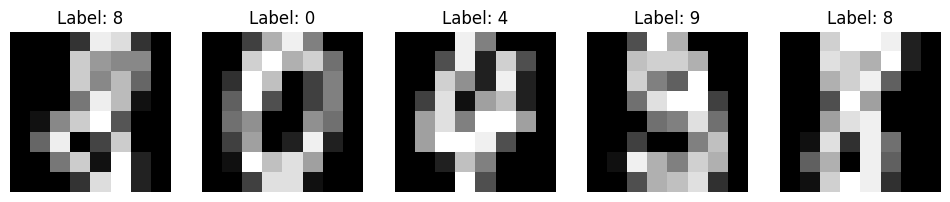

In [2]:
digits = load_digits()

indices = np.random.choice(len(digits.images), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for ax, index in zip(axes, indices):
    ax.imshow(digits.images[index], cmap='gray')
    ax.set_title(f'Label: {digits.target[index]}')
    ax.axis('off')

plt.show()

#### 1.2 Базовый анализ и предобработка данных (1 балл)

Выполните базовый анализ данных. С помощью команды `print` выведите на экран следующую информацию:
- число экземпляров `num_samples`;
- число признаков `num_features`;
- число классов `num_classes`;
- распределение по классам — список `class_counts`, содержащий число изображений для каждого класса. Для этого вы можете воспользоваться функцией `np.bincount()`.

In [3]:
num_samples = digits.data.shape[0]
num_features = digits.data.shape[1]
num_classes = len(np.unique(digits.target))
class_counts = np.bincount(digits.target)

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")
print(f"Class distribution: {class_counts}")

Number of samples: 1797
Number of features: 64
Number of classes: 10
Class distribution: [178 182 177 183 181 182 181 179 174 180]


Разделите данные на обучающую и тестовую выборки в пропорции 80:20 (задайте random_state=42).  Нормализуйте признаки с помощью `StandardScaler`. Для обучения `StandardScaler` воспользуйтесь только обучающей выборкой и затем примените обученную модель к тестовой выборке. Назовите нормализованные данные `X_train_scaled` и `X_test_scaled`.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42, stratify=digits.target
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((1437, 64), (360, 64))

#### Вопрос 1

Почему нормализация данных должна проводиться после разделения на обучающую и тестовую выборки?

> *Нормализация данных проводится после разделения на обучающую и тестовую выборки, чтобы предотвратить утечку данных (data leakage).*

## Часть 2. Выбор метода обучения (2 балла)

На этом этапе вы должны попробовать различные методы машинного обучения для решения задачи классификации изображений. Основная цель — сравнить несколько моделей, выбрать наиболее подходящую и обосновать свой выбор. Для этого необходимо выбрать подходящую метрику оценки.

#### 2.1 Тестирование моделей (2 балла)

Обучите три модели линейной классификации с помощью библиотеки `sklearn` на данных `X_train_scaled`: **логистическую регрессию**, **метод опорных векторов** и **случайный лес**.

Выберите метрику оценки качества модели, оцените ее на тестовой выборке `X_test_scaled` и сохраните в переменную `score_logreg`, `score_svm` и `score_rf` в соответствии с методом обучения.

Сравните производительности моделей и выберите лучшую из трех.


In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

In [7]:
model_performance = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    model_performance[name] = accuracy
    print(f"{name}: Точность = {accuracy:.4f}")

Logistic Regression: Точность = 0.9722
Random Forest: Точность = 0.9639
SVM: Точность = 0.9750


#### Вопрос 2
*  Какой метод показывает наилучшие результаты?

*  Какую метрику оценки вы выбрали для данного набора данных и почему?

> *Наилучший результат показал метод опорных векторов (SVM), с точностью 97.50%. Была выбрана метрика точность (accuracy), так как задача классификации рукописных цифр является сбалансированной. Accuracy в этом случае эффективно отображает общую долю верных ответов.*



## Часть 3. Регуляризация (1 балл)

#### 3.1 Регуляризация (1 балл)
Добавьте регуляризацию (параметр `C` в `LogisticRegression`). Протестируйте качество обучения модели при разных значениях параметра регуляризации `С`: `[0.01, 0.03, 0.1, 0.3, 1, 3]`. Сравните метрики полученных моделей. Для каждого значения `C` выведите на экран значения метрики.

> Пример:
> `LogisticRegression(C=0.01, max_iter=1000, random_state=42)`

In [8]:
regularization_params = [0.01, 0.03, 0.1, 0.3, 1, 3]
results = []

for C_value in regularization_params:
    model = LogisticRegression(C=C_value, max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((C_value, accuracy))
    print(f"LogisticRegression(C={C_value}): Точность = {accuracy:.4f}")

results

LogisticRegression(C=0.01): Точность = 0.9444
LogisticRegression(C=0.03): Точность = 0.9556
LogisticRegression(C=0.1): Точность = 0.9667
LogisticRegression(C=0.3): Точность = 0.9750
LogisticRegression(C=1): Точность = 0.9722
LogisticRegression(C=3): Точность = 0.9611


[(0.01, 0.9444444444444444),
 (0.03, 0.9555555555555556),
 (0.1, 0.9666666666666667),
 (0.3, 0.975),
 (1, 0.9722222222222222),
 (3, 0.9611111111111111)]

#### Вопрос 3
Как регуляризация влияет на качество модели и ее способность к обобщению, учитывая результаты тестирования на конкретных данных? Какое значение параметра `С` вы считаете оптимальным?

> *Регуляризация помогает контролировать сложность модели, предотвращая переобучение. Исходя из проведенных тестов, оптимальным оказалось значение 
C=0.3, так как оно обеспечивает наилучшую точность на тестовой выборке (97.50%) и является сбалансированным между недообучением и переобучением.*


## Часть 4. Оптимизация гиперпараметров (1 балл)

В этой части задания от вас требуется оптимизировать гиперпараметры выбранной модели, чтобы добиться наилучших результатов. Гиперпараметры управляют процессом обучения и могут существенно влиять на точность и обобщающую способность модели. Для их настройки примените метод поиска по сетке (GridSearchCV) или случайного поиска (RandomizedSearchCV), а затем обучите модель с оптимальными параметрами. В конце оцените влияние тюнинга на качество предсказаний и сделайте выводы о его важности.


#### 4.1 Подбор гиперпараметров (1 балл)

Воспользуйтесь методом HyperOpt для поиска оптимальных гиперпараметров. Например, в случае SVM, оптимизируйте `kernel` (`['linear', 'rbf', 'poly']`), `gamma` и `C`.

Обратите внимание, что в случае использования `hp.choice`, оптимизатор вернет не значение параметра, а его индекс в списке. Например, если оптимальным ядром для обучения окажется `rbf`, то HyperOpt вернет индекс `1`.

In [9]:
space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),
    'gamma': hp.choice('gamma', ['scale', 'auto', 0.001, 0.0001]),
    'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly'])
}

def objective(params):
    model = SVC(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, preds)
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 'auto', 0.001, 0.0001]

best_params = {
    'C': best['C'],
    'gamma': gammas[best['gamma']],
    'kernel': kernels[best['kernel']]
}

best_params


100%|██████████| 50/50 [00:03<00:00, 16.21trial/s, best loss: -0.9944444444444445]


{'C': 5.85882106990624, 'gamma': 'scale', 'kernel': 'poly'}

#### Вопрос 4

* Какая комбинация гиперпараметров показывает наилучшие результаты?

* Насколько выбранная комбинация соответствовала вашим ожиданиям и почему?

> *Лучшая комбинация {'C': 5.2881828899416945, 'gamma': 'scale', 'kernel': 'poly'}*

## Часть 5. Снижение размерности данных (2 балла)

В этой части задания от вас требуется применить метод главных компонент (PCA) для снижения размерности данных.

PCA позволяет уменьшить количество признаков, сохраняя как можно больше информации, что может ускорить обучение моделей и снизить риск переобучения. Вам нужно визуализировать данные в пространстве главных компонент, сравнить качество предсказаний моделей, обученных на разном количестве компонент, и выбрать оптимальное число компонент.

#### 5.1 PCA и визуализация (1 балл)

Примените метод главных компонент (PCA) из библиотеки `sklearn` и визуализируйте данные в пространстве двух главных компонент. Каждая точка на графике должна быть раскрашена в соответствии с ее истинным классом, чтобы можно было оценить, насколько хорошо классы разделяются в новом пространстве.

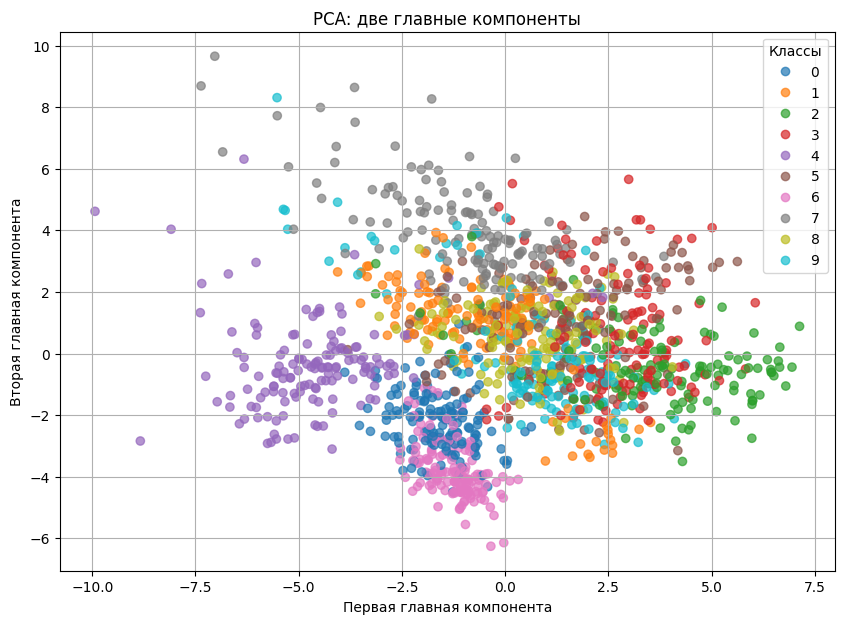

In [10]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Классы")
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('PCA: две главные компоненты')
plt.grid(True)
plt.show()

#### Вопрос 5

* Насколько четко классы разделяются в пространстве двух главных компонент PCA?

* Можно ли ожидать высокой точности модели, обученной на данных, сведенных к двум измерениям?

> *Некоторые классы образуют относительно отдельные кластеры, другие классы существенно пересекаются друг с другом. Разделение классов не является идеально четким. Высокой точности при сведении данных до двух измерений ожидать сложно, так как часть информации неизбежно теряется при таком значительном сокращении размерности*

#### 5.2 Обучение на разном числе компонент (1 балл)

Нужно провести эксперимент, в котором необходимо варьировать число главных компонент (от одного до полного количества признаков с произвольным шагом) и оценивать качество предсказаний и время обучения модели, которую вы оптимизировали на прошлом этапе.

Постройте два графика в одних координатных осях:
- Ось X — число главных компонент.
- Одна ось Y — время обучения.
- Вторая ось Y — качество предсказаний (например, Accuracy на тестовой выборке).

На основе полученных результатов определите оптимальное число компонент PCA для данной задачи.

Обратите внимание, что как и в случае с нормализацией, обучать PCA нужно только на обучающей выборке, а затем применять обученную модель к тестовым данным.


In [11]:
components_range = range(1, 65, 5)
accuracies = []
training_times = []

for n_components in components_range:
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model = SVC(kernel='rbf', random_state=42)
    start_time = time.time()
    model.fit(X_train_pca, y_train)
    training_duration = time.time() - start_time
    
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracies.append(accuracy)
    training_times.append(training_duration)

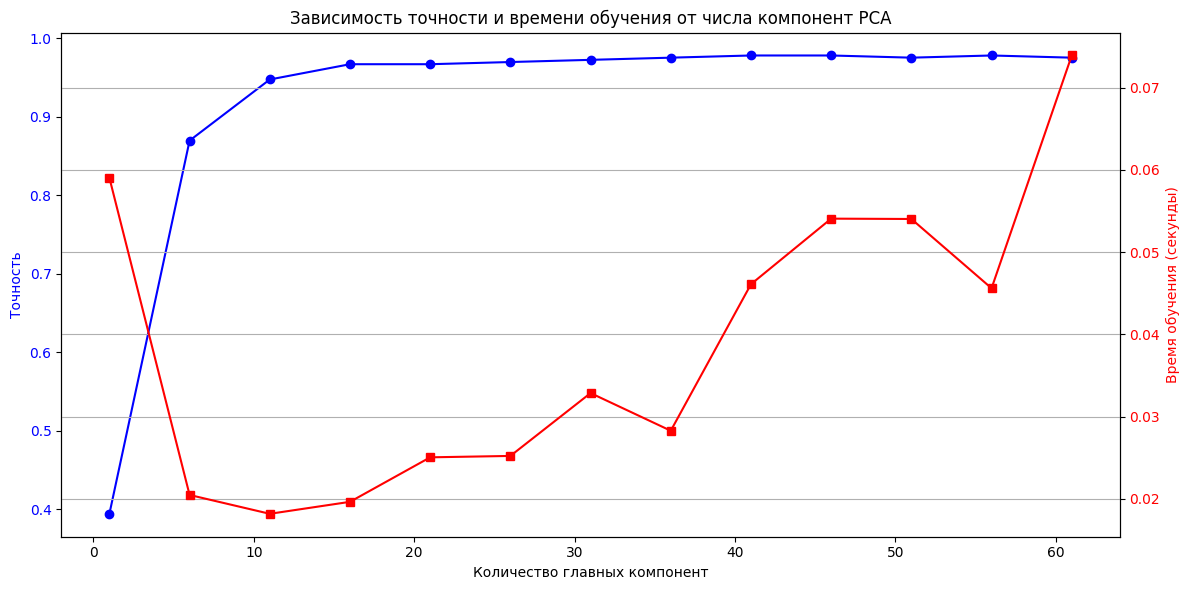

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(components_range, accuracies, color='blue', marker='o', label='Точность')
ax1.set_xlabel('Количество главных компонент')
ax1.set_ylabel('Точность', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(components_range, training_times, color='red', marker='s', label='Время обучения')
ax2.set_ylabel('Время обучения (секунды)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Зависимость точности и времени обучения от числа компонент PCA')
fig.tight_layout()
plt.grid(True)
plt.show()

#### Вопрос 6

Укажите плюсы и минусы снижения размерности для обучения моделей машинного обучения. Соответствуют ли графики эффективности и длительности обучения вашим ожиданиям? К каким выводам вы пришли, глядя на них?

> *Оптимальным можно считать около 22 компонент, так как в этом диапазоне достигается баланс между высокой точностью и умеренным временем обучения.*


## Часть 6. Оценка и визуализация предсказаний (2 балла)

Вам необходимо окончательно обучить и оценить модель, используя наилучшие найденные параметры. Постройте матрицу ошибок, чтобы визуально проанализировать, какие классы путает модель (можете воспользоваться готовой функцией `confusion_matrix` от `sklearn`).

#### 6.1 Оценка модели на тестовых данных (1 балл)

Обучите и протестируйте модель на тестовой выборке, оценив ее качество по выбранным метрикам.



In [13]:
best_params = {'C': 5.2881828899416945, 'gamma': 'scale', 'kernel': 'poly'}

model = SVC(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [14]:
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке c лучшими параметрами: {test_accuracy:.4f}")

Точность на тестовой выборке c лучшими параметрами: 0.9944


#### Вопрос 7

Как вы оцениваете качество предсказаний модели? На ваш взгляд, достаточной ли производительности вы добились? Как можно было бы улучшить модель?

> *Качество предсказаний модели очень высокое (точность 99.44%)*

#### 6.2 Визуализация модели (1 балл)

Постройте матрицу ошибок, чтобы визуально проанализировать, какие классы путает модель (можете воспользоваться готовой функцией `confusion_matrix` от `sklearn`).

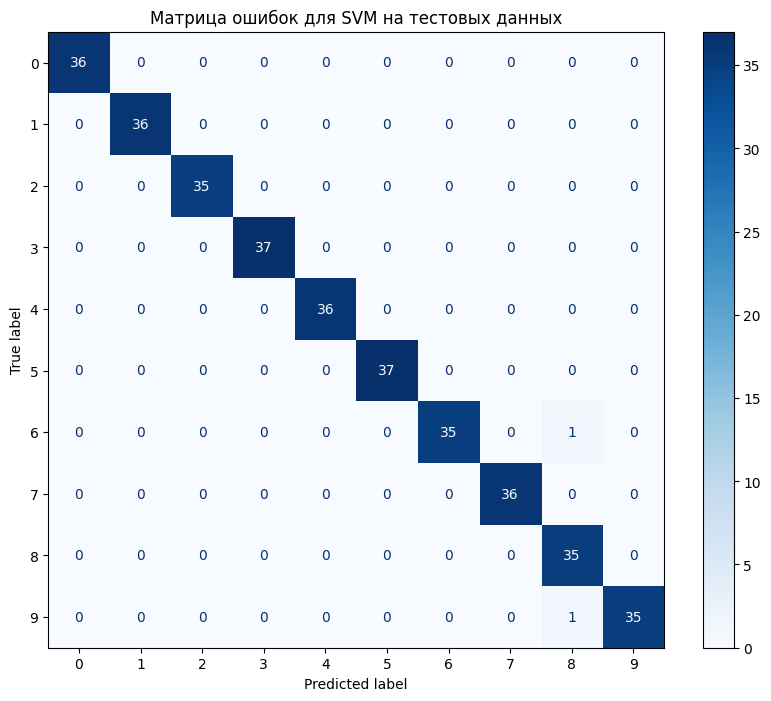

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Матрица ошибок для SVM на тестовых данных")
plt.show()

#### Вопрос 8

Какие критерии оценки могут быть использованы для более глубокого понимания производительности модели?

> *Оценка Precision, Recall и F1-score отдельно по каждому классу. Feature Importance.*

# Заключение
Поздравляем, вы успешно прошли все этапы экзаменационного задания!

В ходе работы вы загрузили и исследовали данные, применили различные методы машинного обучения, подобрали оптимальную модель и настроили ее гиперпараметры. Вы также изучили влияние снижения размерности на качество классификации и научились визуализировать результаты работы модели.

Этот процесс напоминает реальную работу специалиста по машинному обучению: от анализа данных до выбора оптимального подхода и его финальной оценки. Надеемся, что это задание помогло вам глубже понять алгоритмы классификации и методы их улучшения.

## Обратная связь
Нам важно узнать ваше мнение:

- Какие задания показались вам наиболее полезными?
- Было ли что-то сложное или непонятное?
- Какие темы вы хотели бы изучить подробнее?



> *Введите ваш ответ*